In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr

sns.set_context("talk")

## DRR rendering

`DiffDRR` is implemented as a custom PyTorch module.

All raytracing operations have been formulated in a vectorized function, enabling use of PyTorch's GPU support and autograd.
This also means that DRR generation is available as a layer in deep learning frameworks.

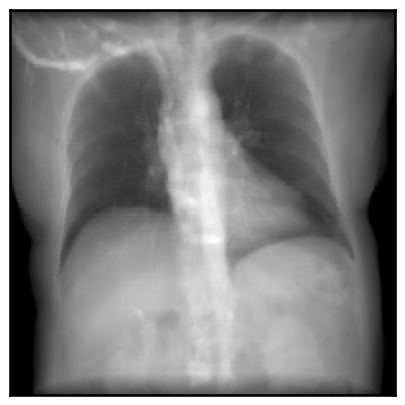

In [ ]:
#| cuda
# Read in the volume and get its origin and spacing in world coordinates
subject = load_example_ct()

# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(
    subject,  # A torchio.Subject object storing the CT volume, origin, and voxel spacing
    sdd=1020,  # Source-to-detector distance (i.e., the C-arm's focal length)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=2.0,  # Pixel spacing (in mm)
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[0.0, 0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 850.0, 0.0]], device=device)
img = drr(rotations, translations, parameterization="euler_angles", convention="ZXY")
plot_drr(img, ticks=False)
plt.show()

We demonstrate the speed of `DiffDRR` by timing repeated DRR synthesis. Timing results are on a single NVIDIA RTX 2080 Ti GPU.

In [ ]:
#| cuda
%timeit drr(rotations, translations, parameterization="euler_angles", convention="ZXY")

38.4 ms ± 62.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Labelmap rendering

We can project labels in 3D (e.g., obtained by TotalSegmentator) into 2D using `DiffDRR`.

100%|████████████████████████████████████████| 6/6 [00:04<00:00,  1.22it/s]


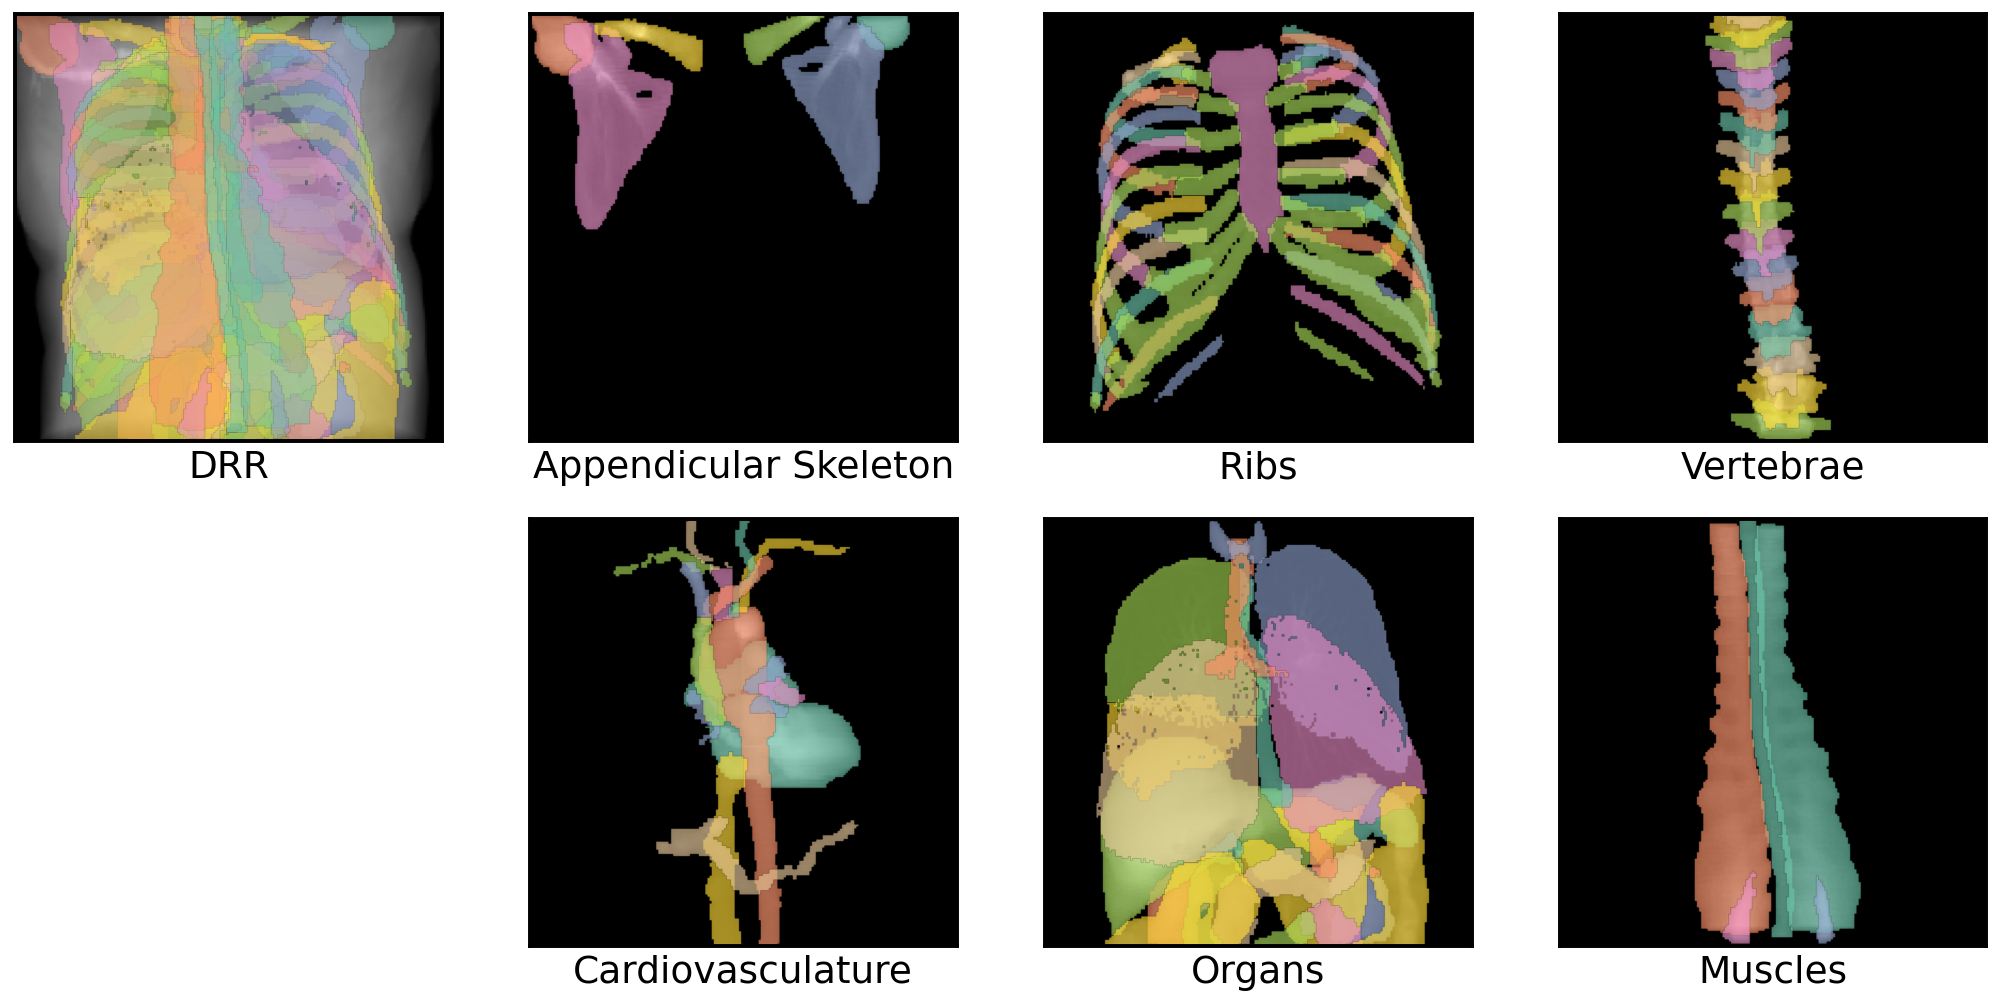

In [ ]:
from itertools import cycle

import numpy as np
from tqdm import tqdm

from diffdrr.pose import convert

# Define a colormap
colors = [
    "rgb(102,194,165)",
    "rgb(252,141,98)",
    "rgb(141,160,203)",
    "rgb(231,138,195)",
    "rgb(166,216,84)",
    "rgb(255,217,47)",
    "rgb(229,196,148)",
]
colors = [[int(c) for c in color[4:][:-1].split(",")] for color in colors]

# Render masks for individual structures
pose = convert(
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZXY",
)
imgs = [drr(pose)]
paints = []

for group in tqdm(
    ["skeleton", "ribs", "vertebrae", "cardiac", "organs", "muscles"], ncols=75
):
    idxs = subject.structures.query(f"group == '{group}'")["id"].tolist()

    # Make the full image
    img = drr(pose, labels=idxs)
    imgs.append(img)

    # Make the masks
    masks = []
    for idx in idxs:
        img = drr(pose, labels=idx)
        mask = img > 0
        masks.append(mask)

    # Color the masks
    paint = []
    for mask, color in zip(masks, cycle(colors)):
        mask = mask.cpu().squeeze()
        h, w = mask.shape
        x = torch.zeros(h, w, 4)
        x[..., 0] = color[0]
        x[..., 1] = color[1]
        x[..., 2] = color[2]
        x[..., 3] = 255
        x = x * mask.unsqueeze(-1)
        x = x.to(torch.uint8)
        paint.append(x)
    paints.append(paint)


# Plot the labelmaps
# plt.rcParams.update({"font.size": 16})
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(14, 7), tight_layout=True, dpi=150)
axs[1, 0].remove()
axs = np.delete(axs.flatten(), 4)
titles = [
    "DRR",
    "Appendicular Skeleton",
    "Ribs",
    "Vertebrae",
    "Cardiovasculature",
    "Organs",
    "Muscles",
]
plot_drr(torch.concat(imgs), title=titles, axs=axs.flatten(), ticks=False)
for masks, ax in zip(paints, axs.flatten()[1:]):
    for mask in masks:
        axs[0].imshow(mask, alpha=0.5)
        ax.imshow(mask, alpha=0.625)
plt.show()

## Sparse rendering

You can also render random sparse subsets of the pixels in a DRR.

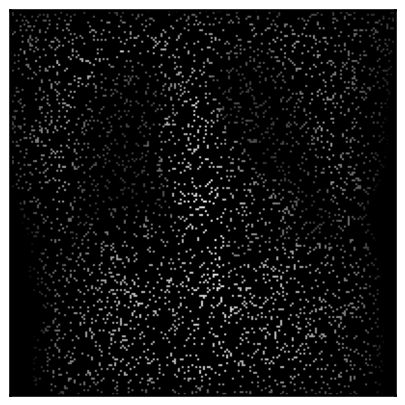

In [ ]:
#| cuda
# Make the DRR with 10% of the pixels
drr = DRR(
    subject,
    sdd=1020,
    height=200,
    delx=2.0,
    p_subsample=0.1,  # Set the proportion of pixels that should be rendered
    reshape=True,  # Map rendered pixels back to their location in true space - useful for plotting, but can be disabled if using MSE as a loss function
).to(device)

# Make the DRR
img = drr(rotations, translations, parameterization="euler_angles", convention="ZXY")
plot_drr(img, ticks=False)
plt.show()

In [ ]:
%timeit drr(rotations, translations, parameterization="euler_angles", convention="ZXY")

6.47 ms ± 4.43 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Batched DRR rendering

The tensors for `rotations` are expected to be of the size `[batch_size, c]`, where `c` is the number of components needed to represent the rotation (`3, 4, 6, 10`).
The tensors for `translations` are expected to be of the size `[batch_size, 3]`.

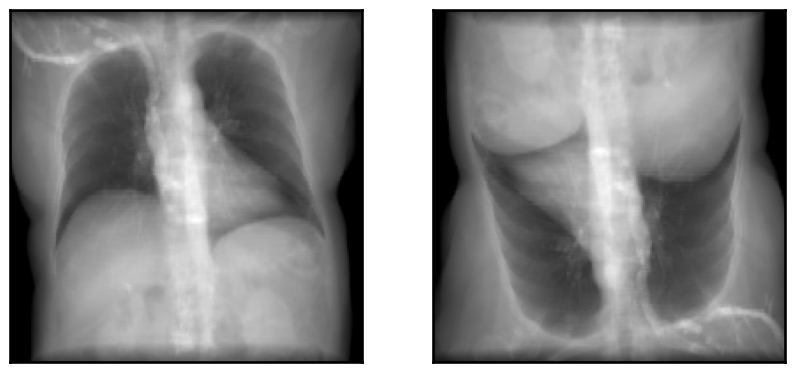

In [ ]:
subject = load_example_ct()

drr = DRR(
    subject,
    sdd=1020,
    height=200,
    delx=2.0,
).to(device)

rotations = torch.tensor([[0.0, 0.0, 0.0], [0.0, 0.0, torch.pi]], device=device)
translations = torch.tensor([[0.0, 850.0, 0.0], [0.0, 850.0, 0.0]], device=device)
img = drr(rotations, translations, parameterization="euler_angles", convention="ZXY")
plot_drr(img, ticks=False)
plt.show()

## Different renderers

`DiffDRR` can also render synthetic X-rays using trilinear interpolation instead of Siddon's method. The key argument to pay attention to is `n_points`, which controls how many points are sampled along each ray for interpolation. Higher values make more realistic images, at the cost of higher rendering time.

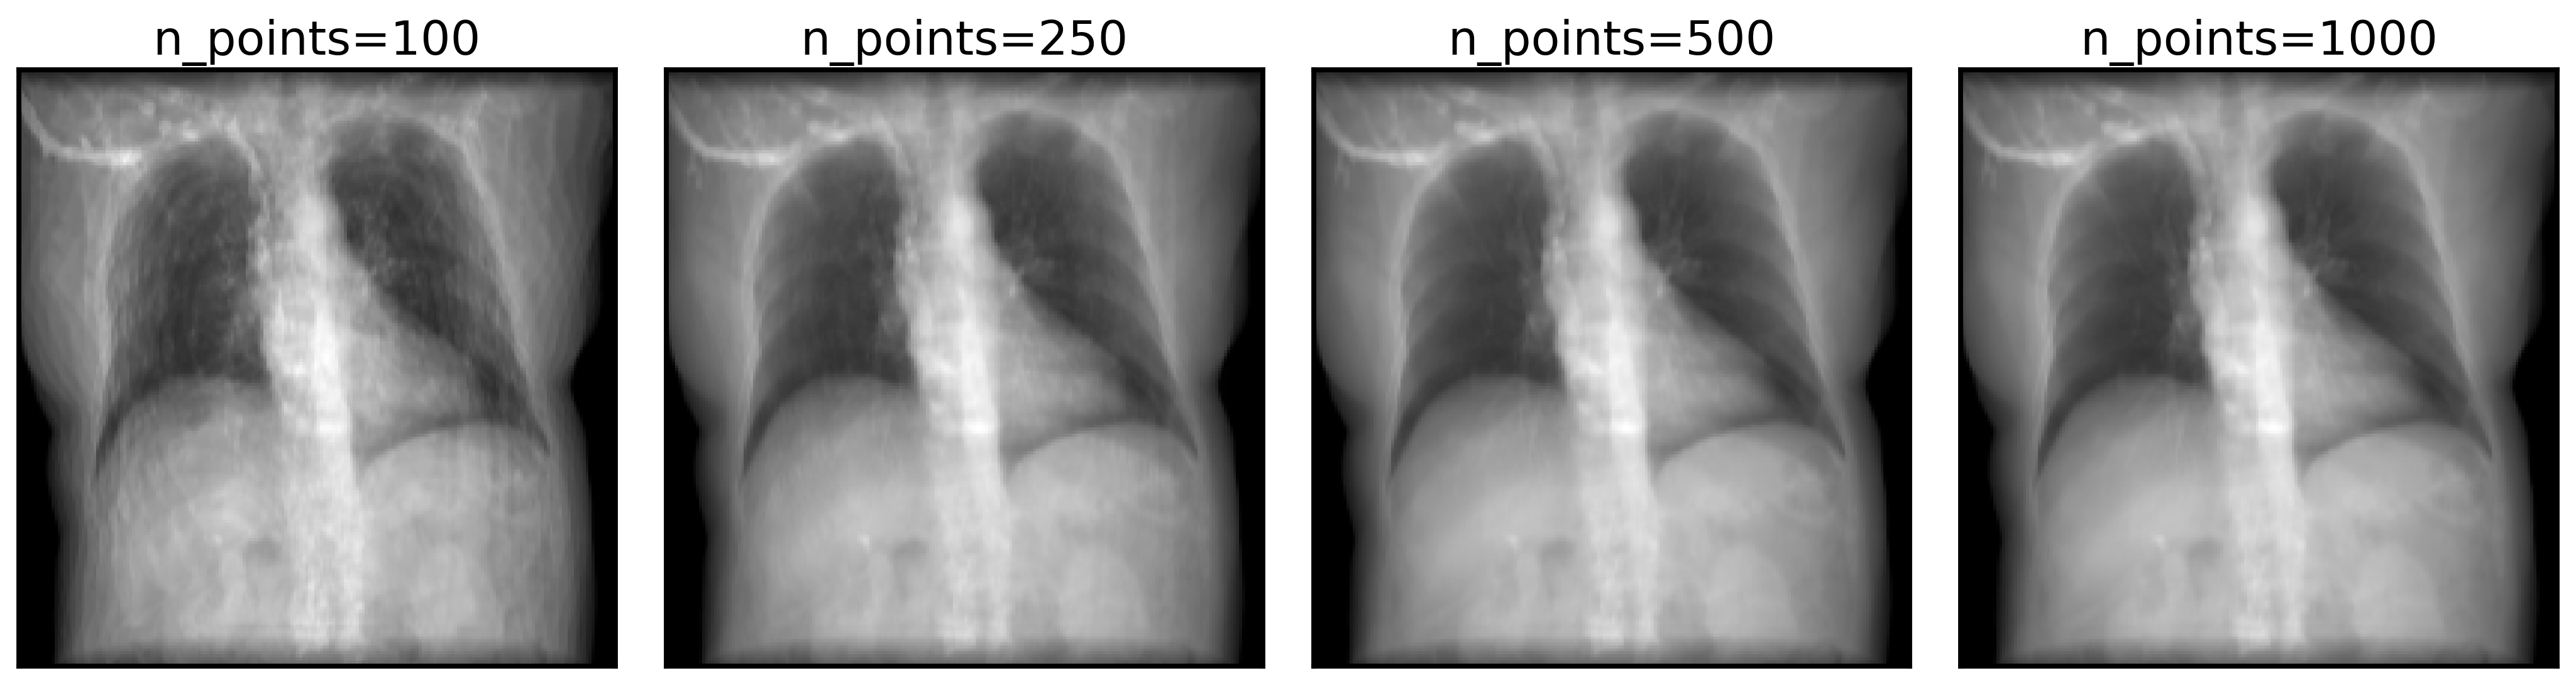

In [ ]:
# Completely downweight bones in CT (i.e., only soft tissue)
drr = DRR(
    subject,
    sdd=1020,
    height=200,
    delx=2.0,
    renderer="trilinear",
).to(device)

rotations = torch.tensor([[0.0, 0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 850.0, 0.0]], device=device)

imgs = []
n_points = [100, 250, 500, 1000]
for n in n_points:
    img = drr(
        rotations,
        translations,
        parameterization="euler_angles",
        convention="ZXY",
        n_points=n,
    )
    imgs.append(img)

fig, axs = plt.subplots(1, 4, figsize=(14, 7), dpi=300, tight_layout=True)
img = torch.concat(imgs)
axs = plot_drr(img, ticks=False, axs=axs)
for idx, n in enumerate(n_points):
    axs[idx].set(title=f"n_points={n}")
plt.show()